In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from pprint import pprint
import folium

In [8]:
metadata = pd.read_csv('../data/metadata.csv')
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


# Geo viz 

In [12]:
import geopandas as gpd
from shapely.geometry import Point

gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [31]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
world

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)
...,...,...
238,Rio de Janeiro,POINT (-43.21212 -22.90731)
239,São Paulo,POINT (-46.62697 -23.55673)
240,Sydney,POINT (151.21255 -33.87137)
241,Singapore,POINT (103.85387 1.29498)


<AxesSubplot:>

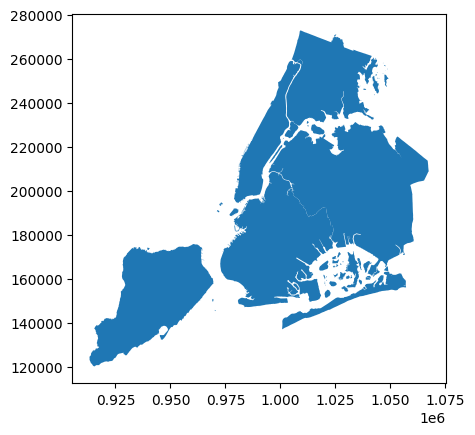

In [33]:
world = gpd.read_file(gpd.datasets.get_path('nybb'))
world.plot()

<AxesSubplot:>

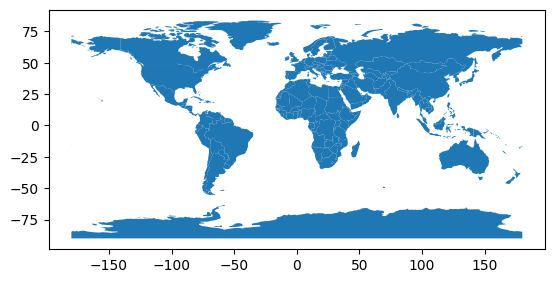

In [35]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

<AxesSubplot:>

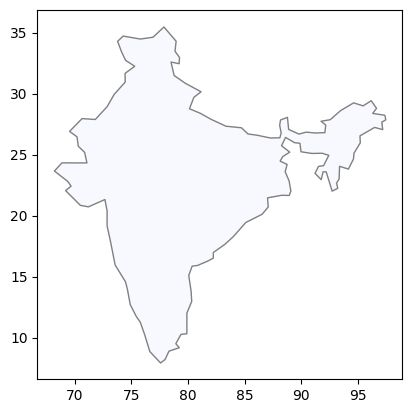

In [22]:
world[world.name == 'India'].plot(edgecolor='gray', color='ghostwhite')

<AxesSubplot:>

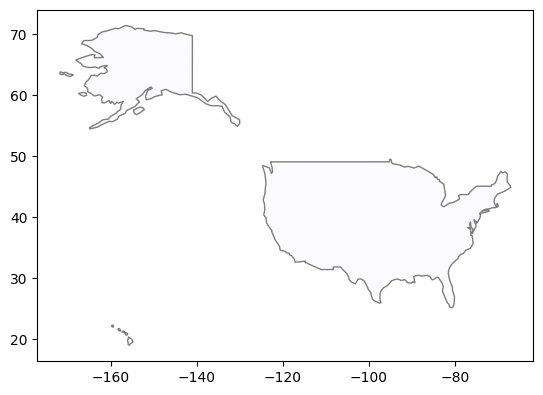

In [36]:
world[world.name == 'United States of America'].plot(edgecolor='black', color='ghostwhite', alpha=0.5)

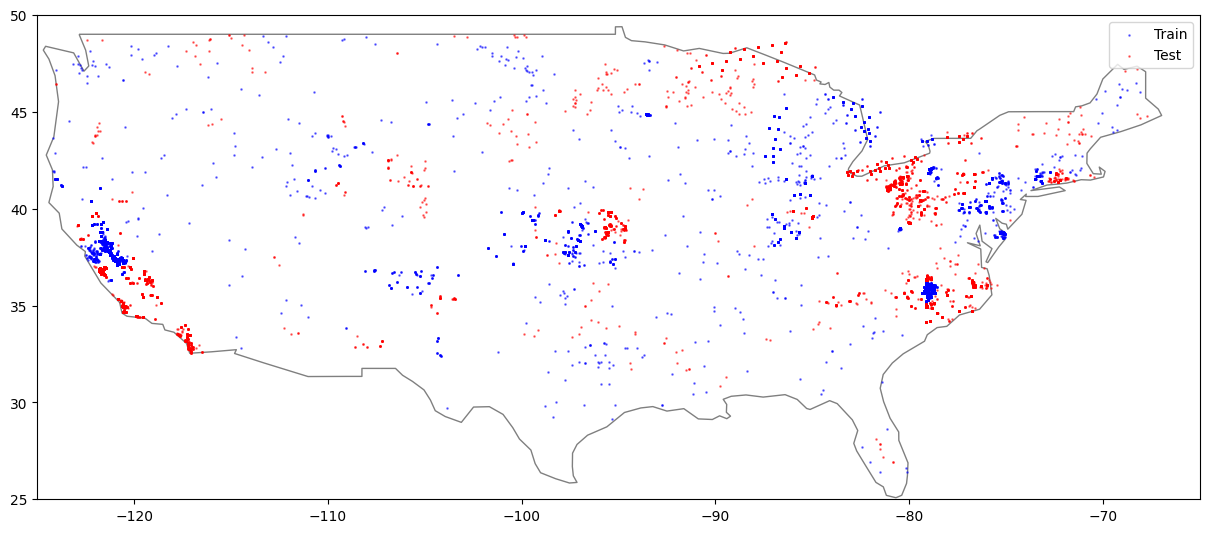

In [42]:
train_meta = metadata[metadata['split'] == 'train']
test_meta = metadata[metadata['split'] == 'test']

base = world[world.name == 'United States of America'].plot(edgecolor='black', color='white', figsize=(15,10), alpha=0.5)

gdf = gpd.GeoDataFrame(train_meta, geometry=gpd.points_from_xy(train_meta.longitude, train_meta.latitude))
gdf.plot(ax=base, marker='.', color='blue', markersize=3, alpha=0.5)

gdf = gpd.GeoDataFrame(test_meta, geometry=gpd.points_from_xy(test_meta.longitude, test_meta.latitude))
gdf.plot(ax=base, marker='.', color='red', markersize=3, alpha=0.5)

plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(['Train', 'Test'])

In [45]:
metadata.date = pd.to_datetime(metadata.date)
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

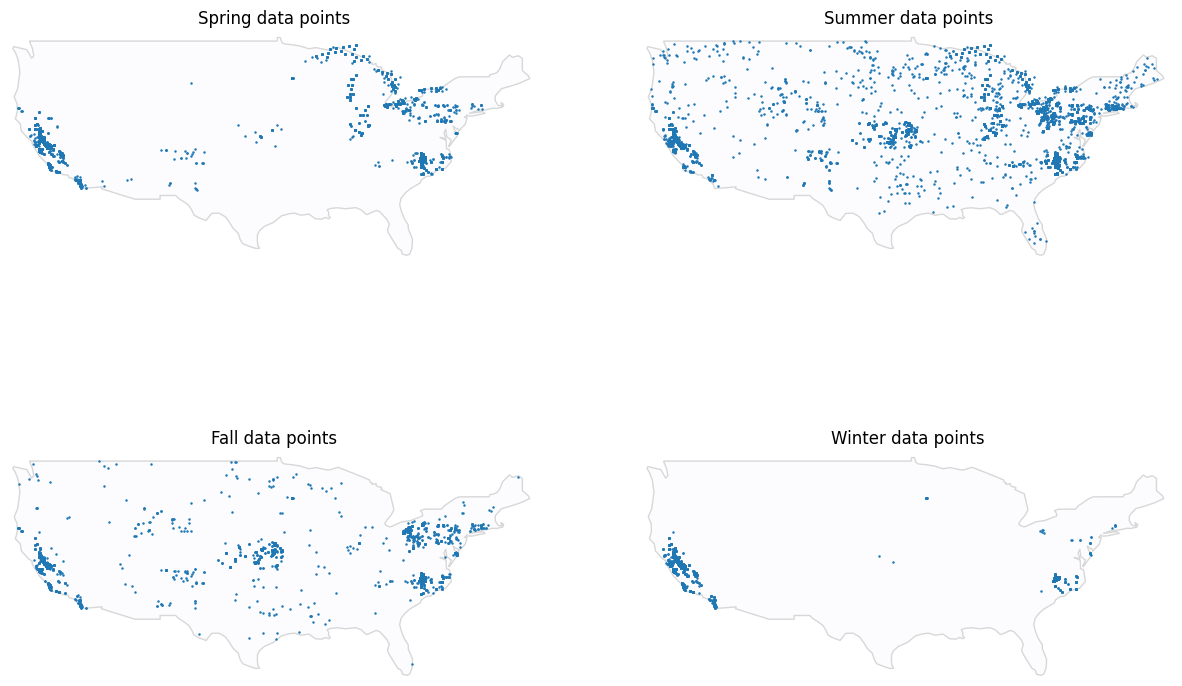

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

<AxesSubplot:>

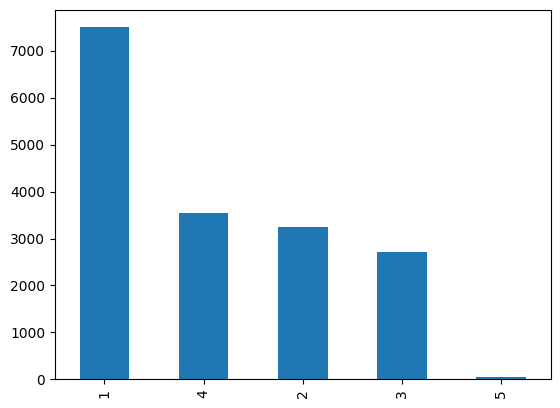

In [49]:
train_labels = pd.read_csv('../data/train_labels.csv')
train_labels.severity.value_counts().plot.bar()

# Pulling Landsat 8 level 1 data from ee

In [1]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [10]:
metadata.date = pd.to_datetime(metadata.date)
metadata.date.min()

Timestamp('2013-01-04 00:00:00')

In [38]:
# ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
landsat_8_data = ee.ImageCollection("LANDSAT/LC08/C02/T1")
landsat_8_data.filterDate(
    start='2013-04-04',
    opt_end='2013-04-12',  # 1 week in april 2013
)
# landsat_8_data.
# landsat_8_data.select(['B1', 'B2', 'B3', 'B4', 'B5'])
rgb_imgs = landsat_8_data.select(['B4', 'B3', 'B2'])
# rgb_imgs.getInfo()

In [36]:
lat, long = metadata[['latitude', 'longitude']].iloc[0]
lat, long

(39.0803190688889, -86.4308666666667)

In [26]:
import geopy.distance as distance

def get_bufferbox(lat, long):
    distance_search = distance.distance(meters=10_000)  # 10km around our point of intrest
    min_lat = distance_search.destination((lat, long), bearing=180)[0]
    min_long = distance_search.destination((lat, long), bearing=270)[1]
    max_lat = distance_search.destination((lat, long), bearing=0)[0]
    max_long = distance_search.destination((lat, long), bearing=90)[1]
    return (min_lat, min_long, max_lat, max_long)

In [39]:
get_bufferbox(lat, long)

(38.990242088205385, 39.17039465411071, -86.54643562285038, -86.31529771048302)

In [50]:
img = rgb_imgs.filterBounds(ee.Geometry.Point(long, lat))
img = ee.Image(img)
img_info = img.getInfo()
img_info

{'type': 'ImageCollection',
 'bands': [],
 'version': 1671935339486807,
 'id': 'LANDSAT/LC08/C02/T1',
 'features': [{'type': 'Image',
   'bands': [{'id': 'B4',
     'data_type': {'type': 'PixelType',
      'precision': 'int',
      'min': 0,
      'max': 65535},
     'dimensions': [7551, 7391],
     'crs': 'EPSG:32616',
     'crs_transform': [30, 0, 438285, 0, -30, 4416615]},
    {'id': 'B3',
     'data_type': {'type': 'PixelType',
      'precision': 'int',
      'min': 0,
      'max': 65535},
     'dimensions': [7551, 7391],
     'crs': 'EPSG:32616',
     'crs_transform': [30, 0, 438285, 0, -30, 4416615]},
    {'id': 'B2',
     'data_type': {'type': 'PixelType',
      'precision': 'int',
      'min': 0,
      'max': 65535},
     'dimensions': [7551, 7391],
     'crs': 'EPSG:32616',
     'crs_transform': [30, 0, 438285, 0, -30, 4416615]}],
   'id': 'LANDSAT/LC08/C02/T1/LC08_021033_20130408',
   'version': 1632833560169448,
   'properties': {'RADIANCE_MULT_BAND_5': 0.0060958,
    'RADIA

In [51]:
img_info.keys()

dict_keys(['type', 'bands', 'version', 'id', 'features'])

In [74]:
img_info['features'][14].keys()

dict_keys(['type', 'bands', 'id', 'version', 'properties'])

In [78]:
img_info['features'][14]['properties']

{'RADIANCE_MULT_BAND_5': 0.0063208,
 'RADIANCE_MULT_BAND_6': 0.0015719,
 'RADIANCE_MULT_BAND_3': 0.012249,
 'RADIANCE_MULT_BAND_4': 0.010329,
 'RADIANCE_MULT_BAND_1': 0.012981,
 'RADIANCE_MULT_BAND_2': 0.013292,
 'WRS_TYPE': 2,
 'K2_CONSTANT_BAND_11': 1201.1442,
 'K2_CONSTANT_BAND_10': 1321.0789,
 'system:footprint': {'type': 'LinearRing',
  'coordinates': [[-84.80907307953639, 39.55366969696636],
   [-84.81140109352481, 39.55431955252501],
   [-84.88573248557041, 39.56890875180005],
   [-86.62269907979866, 39.89446510685095],
   [-86.96269083107737, 39.954806766328495],
   [-86.97490186991742, 39.95689848426167],
   [-86.97557259703288, 39.95535148049739],
   [-87.47699810541049, 38.23979430627305],
   [-87.47698828290974, 38.23829179691592],
   [-87.47016378510004, 38.23697536273761],
   [-86.94163984856326, 38.14056609265563],
   [-85.44977239133817, 37.85417457180702],
   [-85.36338459454919, 37.83695242512791],
   [-85.36243937091004, 37.83767617242221],
   [-85.30625611997641, 38

In [44]:
image = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_044034_20140318')
image_viz_params = {
    'bands': ['B5', 'B4', 'B3'],
    'min': 0,
    'max': 0.5,
    'gamma': [0.95, 1.1, 1]
}

map_l8 = folium.Map(location=[37.5010, -122.1899], zoom_start=10)
map_l8.addLayer(image, image_viz_params, 'false color composite')
display(map_l8)
# image.getInfo()

AttributeError: 'Map' object has no attribute 'addLayer'

In [28]:
landsat_8_data.filterBounds(get_bufferbox(lat, long))

EEException: Invalid GeoJSON geometry.